# CS 681 Assignment 2 Muhammad Adnan Rizqullah 2403851

## Dataset download
In this step goal is to make the dataset ready to be used in the Jupyter notebook runtime. the dataset gets downloaded into the runtime of the Jupyter notebook for further processing.

In [7]:
import requests
import os
import time
from tqdm import tqdm

def download_file(url, destination, force=True):
    """
    Download a file from a URL with a user-friendly progress bar
    """
    if os.path.exists(destination) and not force:
        print(f"Found existing file: {destination}")
        print("Skipping download (use force=True to redownload)")
        return True

    if "github.com" in url and "/blob/" in url:
        url = url.replace("github.com", "raw.githubusercontent.com").replace("/blob/", "/")

    print(f"Starting download from {url}")
    print(f"Saving to: {destination}")

    try:
        response = requests.get(url, 
                              stream=True,
                              headers={'Cache-Control': 'no-cache'},
                              timeout=30)
        
        if response.status_code != 200:
            print(f"Download failed! Server returned code: {response.status_code}")
            return False

        file_size = int(response.headers.get('content-length', 0))
        os.makedirs(os.path.dirname(destination), exist_ok=True)

        with open(destination, 'wb') as f:
            with tqdm(total=file_size, unit='MB', unit_scale=True/1024/1024) as pbar:
                for chunk in response.iter_content(chunk_size=8192):
                    if chunk:
                        f.write(chunk)
                        pbar.update(len(chunk))

        downloaded_size = os.path.getsize(destination)
        if downloaded_size < 10000 and file_size > 10000:
            print(f"Warning: File seems too small ({downloaded_size/1024/1024:.1f} MB)")
            return False

        print(f"Successfully downloaded: {downloaded_size/1024/1024:.1f} MB")
        return True

    except requests.exceptions.RequestException as e:
        print(f"Download failed: {str(e)}")
        return False

# Files to download
files_to_get = {
    "https://github.com/madnanrizqu/cs681-assignment-1/blob/main/aclImdb_v1.tar.gz": "aclImdb_v1.tar.gz",
    "https://github.com/madnanrizqu/cs681-assignment-1/blob/main/imdb_reviews.csv": "imdb_reviews.csv"
}

print("Starting download process...")

for url, filename in files_to_get.items():
    output_path = os.path.join("./", filename)
    if os.path.exists(output_path):
        print(f"{filename} already exists - skipping")
        continue
    
    if not download_file(url, output_path):
        print(f"Failed to download {filename}")

print("Download process completed!")
# Print summary of downloaded files
for filename in files_to_get.values():
    path = os.path.join("./", filename)
    if os.path.exists(path):
        size_mb = os.path.getsize(path) / (1024 * 1024)
        print(f"File {filename}: {size_mb:.1f} MB")
    else:
        print(f"File {filename} not found")

Starting download process...
aclImdb_v1.tar.gz already exists - skipping
imdb_reviews.csv already exists - skipping
Download process completed!
File aclImdb_v1.tar.gz: 8.1 MB
File imdb_reviews.csv: 62.8 MB


In [8]:
import os

target_dir = './'
files = os.listdir(target_dir)
os.chdir(target_dir)
print("Files in current directory:", files)

Files in current directory: ['news.ipynb', '.DS_Store', 'requirements.txt', 'environment.yml', 'imdb.ipynb', 'extracted_imdb', '__pycache__', 'todo.md', 'README.md', 'Assignment 2.pdf', 'aclImdb_v1.tar.gz', '.gitignore', 'imdb_reviews.csv', '.git']


In [9]:
import os
import pandas as pd
from pathlib import Path
import tarfile

def extract_specific_dirs(
    archive_path, output_dir="./extracted_data", target_dirs=None
):
    if target_dirs is None:
        target_dirs = ["train/pos", "train/neg", "test/pos", "test/neg"]

    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)

    print(f"Extracting files to: {output_path.absolute()}")

    with tarfile.open(archive_path, "r:gz") as tar:
        for member in tar.getmembers():
            for target in target_dirs:
                if f"aclImdb/{target}" in member.name:
                    tar.extract(member, output_path)

    print("Extraction completed!")

def count_files_in_dir(directory):
    total_files = 0
    for root, dirs, files in os.walk(directory):
        total_files += len(files)
    return total_files

def process_imdb_data():
    if not os.path.exists("./extracted_imdb"):
        extract_specific_dirs("./aclImdb_v1.tar.gz", output_dir="./extracted_imdb")

    print(
        "Num of positive in test: ",
        count_files_in_dir("./extracted_imdb/aclImdb/test/pos"),
    )
    print(
        "Num of negative in test: ",
        count_files_in_dir("./extracted_imdb/aclImdb/test/neg"),
    )
    print(
        "Num of positive in train: ",
        count_files_in_dir("./extracted_imdb/aclImdb/train/pos"),
    )
    print(
        "Num of negative in train: ",
        count_files_in_dir("./extracted_imdb/aclImdb/train/neg"),
    )

    texts = []
    labels = []

    for split in ["train", "test"]:
        for sentiment in ["pos", "neg"]:
            path = f"./extracted_imdb/aclImdb/{split}/{sentiment}"
            for file in os.listdir(path):
                with open(os.path.join(path, file), "r", encoding="utf-8") as f:
                    texts.append(f.read())
                    labels.append(1 if sentiment == "pos" else 0)

    df = pd.DataFrame({"text": texts, "label": labels })
    print(f"Total samples in DataFrame: {len(df)}")
    df.to_csv("imdb_reviews.csv", index=False)

if not os.path.exists("imdb_reviews.csv"):
    process_imdb_data()
else:
    print("imdb_reviews.csv already exists. Skipping processing.")
    print("""Steps in process_imdb_data:
1. Extracts positive and negative reviews from train and test directories from the tart file

2. Count and print files in each directory:
- test/pos
- test/neg
- train/pos
- train/neg

3. Process text data:
- Reads each review file from all directories
- Stores text content, sentiment labels (1 for pos, 0 for neg)
- Records split type (train or test)

4. Create DataFrame:
- Combines texts, labels, and splits into pandas DataFrame
- Saves DataFrame to 'imdb_reviews.csv'
""")


imdb_reviews.csv already exists. Skipping processing.
Steps in process_imdb_data:
1. Extracts positive and negative reviews from train and test directories from the tart file

2. Count and print files in each directory:
- test/pos
- test/neg
- train/pos
- train/neg

3. Process text data:
- Reads each review file from all directories
- Stores text content, sentiment labels (1 for pos, 0 for neg)
- Records split type (train or test)

4. Create DataFrame:
- Combines texts, labels, and splits into pandas DataFrame
- Saves DataFrame to 'imdb_reviews.csv'



## Dateset exploration
In this step the goal is to know how best to preprocess the dataset. We also want to know whether there are any empty values and whether the dataset has balanced class distribution. 

Dataset shape: (50000, 2)

First 5 rows:
                                                text  label
0  For a movie that gets no respect there sure ar...      1
1  Bizarre horror movie filled with famous faces ...      1
2  A solid, if unremarkable film. Matthau, as Ein...      1
3  It's a strange feeling to sit alone in a theat...      1
4  You probably all already know this by now, but...      1

Columns and data types:
text     object
label     int64
dtype: object

Missing values per column:
text     0
label    0
dtype: int64

Label distribution:
label
1    25000
0    25000
Name: count, dtype: int64


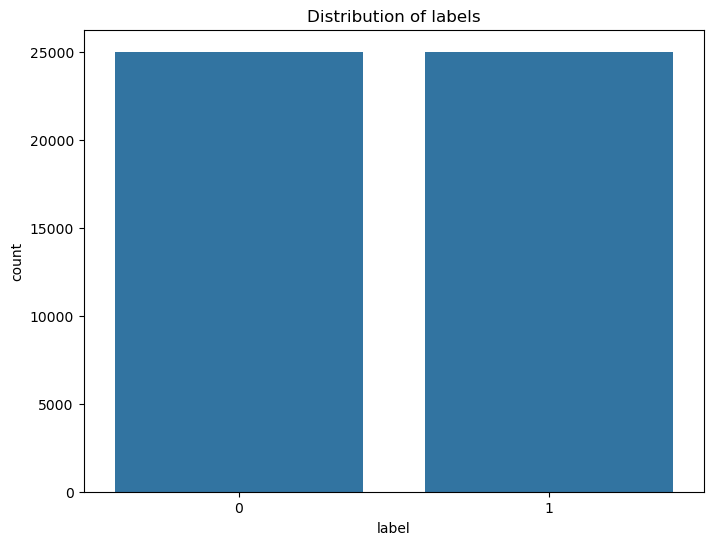


Sample review:
For a movie that gets no respect there sure are a lot of memorable quotes listed for this gem. Imagine a movie where Joe Piscopo is actually funny! Maureen Stapleton is a scene stealer. The Moroni character is an absolute scream. Watch for Alan "The Skipper" Hale jr. as a police Sgt....


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

csv_path = os.path.join("./", "imdb_reviews.csv")
df = pd.read_csv(csv_path)

print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

print("\nColumns and data types:")
print(df.dtypes)

print("\nMissing values per column:")
print(df.isnull().sum())

if 'label' in df.columns:
    print("\nLabel distribution:")
    print(df['label'].value_counts())

    plt.figure(figsize=(8, 6))
    sns.countplot(x='label', data=df)
    plt.title('Distribution of labels')
    plt.show()

text_column = 'text'
print("\nSample review:")
print(df[text_column].iloc[0][:500] + "...")


## Data preprocessing
In this step the goal is to remove unwanted characters from the dataset, the ones that might negatively impact or at least have no value in the machine learning task.

In [11]:
import pandas as pd
import re

def html_remover(text):
    total_chars = len(text)
    text_no_html = re.sub('<[^>]*>', '', text)
    html_chars_removed = total_chars - len(text_no_html)
    return text_no_html, html_chars_removed, total_chars

results = df['text'].apply(html_remover)

html_stats = pd.DataFrame()

df['no_html'] = results.apply(lambda x: x[0])
html_stats['html_filtered_count'] = results.apply(lambda x: x[1])
html_stats['total_chars'] = results.apply(lambda x: x[2])
html_stats.index = df.index

print("\nPreprocessing Statistics:")
print(f"Total characters in dataset: {html_stats['total_chars'].sum():,}")
print(f"Total HTML chars filtered: {html_stats['html_filtered_count'].sum():,}")
print(f"Percentage of HTML chars: {(html_stats['html_filtered_count'].sum() / html_stats['total_chars'].sum() * 100):.2f}%")
print(f"Average HTML chars per review: {html_stats['html_filtered_count'].mean():.2f}")

print("\nExamples where HTML was found:")
html_rows = html_stats[html_stats['html_filtered_count'] > 0].head(3)
if len(html_rows) > 0:
    for idx in html_rows.index:
        print(f"\nExample (Review #{idx}):")
        print(f"Total chars: {html_stats.loc[idx, 'total_chars']}")
        print(f"HTML chars removed: {html_stats.loc[idx, 'html_filtered_count']} ({(html_stats.loc[idx, 'html_filtered_count'] / html_stats.loc[idx, 'total_chars'] * 100):.2f}%)")
        print(f"Original: {df.loc[idx, 'text'][:200]}...")
        print(f"Processed: {df.loc[idx, 'no_html'][:200]}...")
else:
    print("No HTML tags found in the dataset.")



Preprocessing Statistics:
Total characters in dataset: 65,471,551
Total HTML chars filtered: 1,212,813
Percentage of HTML chars: 1.85%
Average HTML chars per review: 24.26

Examples where HTML was found:

Example (Review #3):
Total chars: 2596
HTML chars removed: 96 (3.70%)
Original: It's a strange feeling to sit alone in a theater occupied by parents and their rollicking kids. I felt like instead of a movie ticket, I should have been given a NAMBLA membership.<br /><br />Based up...
Processed: It's a strange feeling to sit alone in a theater occupied by parents and their rollicking kids. I felt like instead of a movie ticket, I should have been given a NAMBLA membership.Based upon Thomas Ro...

Example (Review #6):
Total chars: 648
HTML chars removed: 72 (11.11%)
Original: You're using the IMDb.<br /><br />You've given some hefty votes to some of your favourite films.<br /><br />It's something you enjoy doing.<br /><br />And it's all because of this. Fifty seconds. One ...
Processed:

In [12]:
import pandas as pd
import re

def special_char_remover(text):
    total_chars = len(text)
    text_clean = re.sub(r'[^a-zA-Z0-9\s.,!?-]', '', text)
    special_chars_removed = total_chars - len(text_clean)
    return text_clean, special_chars_removed, total_chars

results = df['no_html'].apply(special_char_remover)

char_stats = pd.DataFrame()

df['no_html_special_chars'] = results.apply(lambda x: x[0])
char_stats['special_chars_removed'] = results.apply(lambda x: x[1])
char_stats['total_chars'] = results.apply(lambda x: x[2])
char_stats.index = df.index

print("\nPreprocessing Statistics:")
print(f"Total characters in dataset: {char_stats['total_chars'].sum():,}")
print(f"Total special chars filtered: {char_stats['special_chars_removed'].sum():,}")
print(f"Percentage of special chars: {(char_stats['special_chars_removed'].sum() / char_stats['total_chars'].sum() * 100):.2f}%")
print(f"Average special chars per review: {char_stats['special_chars_removed'].mean():.2f}")

print("\nExamples where special characters were found:")
special_rows = char_stats[char_stats['special_chars_removed'] > 0].head(3)
if len(special_rows) > 0:
    for idx in special_rows.index:
        print(f"\nExample (Review #{idx}):")
        print(f"Total chars: {char_stats.loc[idx, 'total_chars']}")
        print(f"Special chars removed: {char_stats.loc[idx, 'special_chars_removed']} ({(char_stats.loc[idx, 'special_chars_removed'] / char_stats.loc[idx, 'total_chars'] * 100):.2f}%)")
        print(f"Original: {df.loc[idx, 'no_html'][:200]}...")
        print(f"Processed: {df.loc[idx, 'no_html_special_chars'][:200]}...")
else:
    print("No special characters found in the dataset.")



Preprocessing Statistics:
Total characters in dataset: 64,258,738
Total special chars filtered: 623,938
Percentage of special chars: 0.97%
Average special chars per review: 12.48

Examples where special characters were found:

Example (Review #0):
Total chars: 284
Special chars removed: 2 (0.70%)
Original: For a movie that gets no respect there sure are a lot of memorable quotes listed for this gem. Imagine a movie where Joe Piscopo is actually funny! Maureen Stapleton is a scene stealer. The Moroni cha...
Processed: For a movie that gets no respect there sure are a lot of memorable quotes listed for this gem. Imagine a movie where Joe Piscopo is actually funny! Maureen Stapleton is a scene stealer. The Moroni cha...

Example (Review #1):
Total chars: 1033
Special chars removed: 25 (2.42%)
Original: Bizarre horror movie filled with famous faces but stolen by Cristina Raines (later of TV's "Flamingo Road") as a pretty but somewhat unstable model with a gummy smile who is slated to pay 

In [13]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt_tab')
nltk.download('stopwords')

def stop_words_remover(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text.lower())
    total_words = len(words)
    filtered_words = [word for word in words if word not in stop_words]
    stops_removed = total_words - len(filtered_words)
    processed_text = ' '.join(filtered_words)
    return processed_text, stops_removed, total_words

results = df['no_html_special_chars'].apply(stop_words_remover)

stops_stats = pd.DataFrame()

df['no_html_special_chars_stops'] = results.apply(lambda x: x[0])
stops_stats['stops_removed'] = results.apply(lambda x: x[1])
stops_stats['total_words'] = results.apply(lambda x: x[2])
stops_stats.index = df.index

print("\nPreprocessing Statistics:")
print(f"Total words in dataset: {stops_stats['total_words'].sum():,}")
print(f"Total stop words removed: {stops_stats['stops_removed'].sum():,}")
print(f"Percentage of stop words: {(stops_stats['stops_removed'].sum() / stops_stats['total_words'].sum() * 100):.2f}%")
print(f"Average stop words per review: {stops_stats['stops_removed'].mean():.2f}")

print("\nExamples of stop words removal:")
stop_rows = stops_stats.head(3)
for idx in stop_rows.index:
    print(f"\nExample (Review #{idx}):")
    print(f"Total words: {stops_stats.loc[idx, 'total_words']}")
    print(f"Stop words removed: {stops_stats.loc[idx, 'stops_removed']} ({(stops_stats.loc[idx, 'stops_removed'] / stops_stats.loc[idx, 'total_words'] * 100):.2f}%)")
    print(f"Original: {df.loc[idx, 'no_html_special_chars'][:200]}...")
    print(f"Processed: {df.loc[idx, 'no_html_special_chars_stops'][:200]}...")


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/madnanrizqu/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/madnanrizqu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Preprocessing Statistics:
Total words in dataset: 12,485,027
Total stop words removed: 5,345,643
Percentage of stop words: 42.82%
Average stop words per review: 106.91

Examples of stop words removal:

Example (Review #0):
Total words: 57
Stop words removed: 22 (38.60%)
Original: For a movie that gets no respect there sure are a lot of memorable quotes listed for this gem. Imagine a movie where Joe Piscopo is actually funny! Maureen Stapleton is a scene stealer. The Moroni cha...
Processed: movie gets respect sure lot memorable quotes listed gem . imagine movie joe piscopo actually funny ! maureen stapleton scene stealer . moroni character absolute scream . watch alan skipper hale jr. po...

Example (Review #1):
Total words: 181
Stop words removed: 63 (34.81%)
Original: Bizarre horror movie filled with famous faces but stolen by Cristina Raines later of TVs Flamingo Road as a pretty but somewhat unstable model with a gummy smile who is slated to pay for her attempted...
Processed: biz

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np

vectorizer = CountVectorizer(
    max_features=20000,
)

X = vectorizer.fit_transform(df['no_html_special_chars_stops'])

vocab_df = pd.DataFrame(
    X.toarray(),
    columns=vectorizer.get_feature_names_out()
)

print("\nVectorization Statistics:")
print(f"Number of documents: {X.shape[0]}")
print(f"Vocabulary size: {X.shape[1]}")
print(f"Total words: {X.sum():,}")

word_counts = np.asarray(X.sum(axis=0)).ravel()
word_freq = pd.DataFrame({
    'term': vectorizer.get_feature_names_out(),
    'count': word_counts
})
print("\nTop 10 most frequent terms:")
print(word_freq.sort_values('count', ascending=False).head(10))



Vectorization Statistics:
Number of documents: 50000
Vocabulary size: 20000
Total words: 5,805,122

Top 10 most frequent terms:
         term  count
11819   movie  86993
6860     film  77615
12516     one  53009
10503    like  40113
7749     good  29674
18089    time  25033
6297     even  24832
19796   would  24217
14407  really  23082
15721     see  22981


## Dataset split
In this step we want to have a split where more data is allocated to the training set but enough data is there to evaluate the model properly in the test set.

In [15]:
from sklearn.model_selection import train_test_split

X = df['no_html_special_chars_stops']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(f"Length of X_train: {len(X_train)}")
print(f"Length of y_train: {len(y_train)}")
print(f"Length of X_test: {len(X_test)}")
print(f"Length of y_test: {len(y_test)}")

print("\nLabels in y_train:")
print(y_train.value_counts())
print("\nLabels in y_test:")
print(y_test.value_counts())

Length of X_train: 40000
Length of y_train: 40000
Length of X_test: 10000
Length of y_test: 10000

Labels in y_train:
label
1    20035
0    19965
Name: count, dtype: int64

Labels in y_test:
label
0    5035
1    4965
Name: count, dtype: int64


## Vectorization
In this step we transform the text into numerical representations that can be consumed by the computer and by extension the machine learning algorithms.

In [16]:
import numpy as np
from nltk.tokenize import word_tokenize
import nltk
from gensim.models import Word2Vec

# Download nltk resources if not already downloaded
nltk.download('punkt', quiet=True)

print("Loading pre-trained Word2Vec model...")
try:
    import gensim.downloader as api
    print("Downloading model...")
    w2v_model = api.load("word2vec-google-news-300")
    print("Model loaded successfully")
except Exception as e:
    # If the file is not found, use a smaller model from gensim's downloader
    print(f"Failed to download model: {str(e)}")
    w2v_model = None    

def get_doc_vector(text, model, vector_size=300):
    tokens = word_tokenize(text.lower())
    vectors = [model[word] for word in tokens if word in model]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(vector_size)
    
print("Generating word2vec representation using pre-trained model...")
X_train_w2v = np.array([get_doc_vector(text, w2v_model) for text in X_train])
X_test_w2v = np.array([get_doc_vector(text, w2v_model) for text in X_test])

Loading pre-trained Word2Vec model...
Model loaded successfully
Generating word2vec representation using pre-trained model...


In [17]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = CountVectorizer(max_features=20000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

tfidf_vectorizer = TfidfVectorizer(max_features=20000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

## Base experiment
In this step the goal is to know the performance result without:
1. early stopping
2. dropout
3. regularization
4. batch normalization

Weights initialization is used here to make sure all layers weights are not randomized, ensuring reproduceability

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

X_train_vec_dense = X_train_vec.toarray()
X_test_vec_dense = X_test_vec.toarray()
X_train_tfidf_dense = X_train_tfidf.toarray()
X_test_tfidf_dense = X_test_tfidf.toarray()

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

print("Training Neural Network with BoW features...")
model = Sequential([
      Dense(32, activation='relu', input_shape=(X_train_vec_dense.shape[1],), 
              kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
      Dense(4, activation='relu', 
              kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
      Dense(2, activation='softmax', 
              kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_vec_dense, y_train_cat, epochs=5, batch_size=32, verbose=0)

print("Training Neural Network with TF-IDF features...")
tfidf_model = Sequential([
      Dense(32, activation='relu', input_shape=(X_train_tfidf_dense.shape[1],), 
              kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
      Dense(4, activation='relu', 
              kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
      Dense(2, activation='softmax', 
              kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
])
tfidf_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
tfidf_model.fit(X_train_tfidf_dense, y_train_cat, epochs=5, batch_size=32, verbose=0)

print("Training Neural Network with Word2Vec features...")
w2v_model_lr = Sequential([
      Dense(32, activation='relu', input_shape=(X_train_w2v.shape[1],), 
              kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
      Dense(4, activation='relu', 
              kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
      Dense(2, activation='softmax', 
              kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
])
w2v_model_lr.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
w2v_model_lr.fit(X_train_w2v, y_train_cat, epochs=5, batch_size=32, verbose=0)

print("Testing ann models...")

y_pred_proba = model.predict(X_test_vec_dense)
y_pred_labels = np.argmax(y_pred_proba, axis=1)
accuracy = accuracy_score(y_test, y_pred_labels)
precision = precision_score(y_test, y_pred_labels, average='weighted')
recall = recall_score(y_test, y_pred_labels, average='weighted')
f1 = f1_score(y_test, y_pred_labels, average='weighted')

y_pred_tfidf_proba = tfidf_model.predict(X_test_tfidf_dense)
y_pred_tfidf_labels = np.argmax(y_pred_tfidf_proba, axis=1)
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf_labels)
precision_tfidf = precision_score(y_test, y_pred_tfidf_labels, average='weighted')
recall_tfidf = recall_score(y_test, y_pred_tfidf_labels, average='weighted')
f1_tfidf = f1_score(y_test, y_pred_tfidf_labels, average='weighted')

y_pred_w2v_proba = w2v_model_lr.predict(X_test_w2v)
y_pred_w2v_labels = np.argmax(y_pred_w2v_proba, axis=1)
accuracy_w2v = accuracy_score(y_test, y_pred_w2v_labels)
precision_w2v = precision_score(y_test, y_pred_w2v_labels, average='weighted')
recall_w2v = recall_score(y_test, y_pred_w2v_labels, average='weighted')
f1_w2v = f1_score(y_test, y_pred_w2v_labels, average='weighted')

print("\nModel Comparison:")
print("CountVectorizer + Neural Network:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")
print("\nTF-IDF + Neural Network:")
print(f"  Accuracy:  {accuracy_tfidf:.4f}")
print(f"  Precision: {precision_tfidf:.4f}")
print(f"  Recall:    {recall_tfidf:.4f}")
print(f"  F1-Score:  {f1_tfidf:.4f}")
print("\nWord2Vec + Neural Network:")
print(f"  Accuracy:  {accuracy_w2v:.4f}")
print(f"  Precision: {precision_w2v:.4f}")
print(f"  Recall:    {recall_w2v:.4f}")
print(f"  F1-Score:  {f1_w2v:.4f}")

Training Neural Network with BoW features...


2025-03-15 12:45:34.326562: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Training Neural Network with TF-IDF features...
Training Neural Network with Word2Vec features...
Testing ann models...
313/313 [==============================] - 0s 269us/step

Model Comparison:
CountVectorizer + Neural Network:
  Accuracy:  0.8840
  Precision: 0.8846
  Recall:    0.8840
  F1-Score:  0.8840

TF-IDF + Neural Network:
  Accuracy:  0.8752
  Precision: 0.8758
  Recall:    0.8752
  F1-Score:  0.8751

Word2Vec + Neural Network:
  Accuracy:  0.8446
  Precision: 0.8501
  Recall:    0.8446
  F1-Score:  0.8439


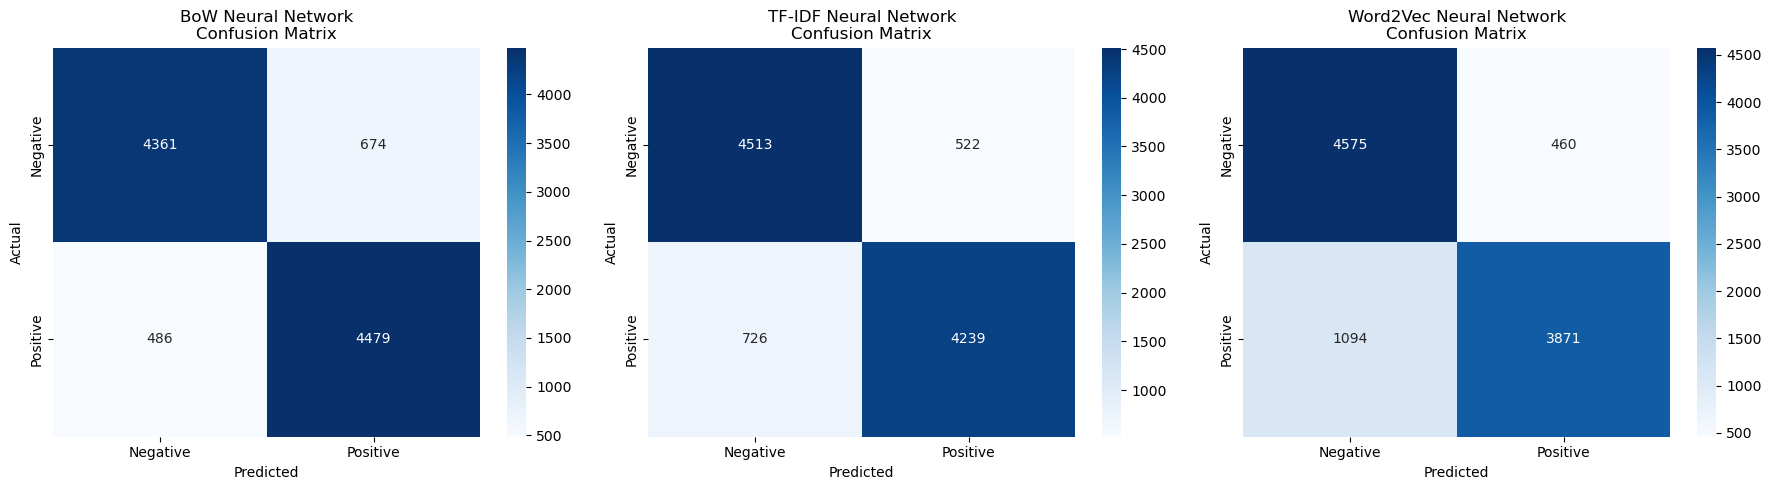

In [19]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_names = ['Negative', 'Positive']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

cm_bow = confusion_matrix(y_test, y_pred_labels)
sns.heatmap(cm_bow, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('BoW Neural Network\nConfusion Matrix')

cm_tfidf = confusion_matrix(y_test, y_pred_tfidf_labels)
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('TF-IDF Neural Network\nConfusion Matrix')


cm_w2v = confusion_matrix(y_test, y_pred_w2v_labels)
sns.heatmap(cm_w2v, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names, ax=axes[2])
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_title('Word2Vec Neural Network\nConfusion Matrix')

plt.tight_layout()
plt.show()

## Dropout
In this step, the effects of dropout towards performance is explored. Other variables are left the same as the base experiment

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

X_train_vec_dense = X_train_vec.toarray()
X_test_vec_dense = X_test_vec.toarray()
X_train_tfidf_dense = X_train_tfidf.toarray()
X_test_tfidf_dense = X_test_tfidf.toarray()

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

print("Training Neural Network with BoW features and dropout...")
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_vec_dense.shape[1],), 
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
    Dropout(0.2),  # Add dropout layer with 20% rate
    Dense(4, activation='relu', 
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
    Dropout(0.1),  # Add dropout layer with 10% rate
    Dense(2, activation='softmax', 
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_vec_dense, y_train_cat, epochs=5, batch_size=32, verbose=0)

print("Training Neural Network with TF-IDF features and dropout...")
tfidf_model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_tfidf_dense.shape[1],), 
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
    Dropout(0.2),  # Add dropout layer with 20% rate
    Dense(4, activation='relu', 
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
    Dropout(0.1),  # Add dropout layer with 10% rate
    Dense(2, activation='softmax', 
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
])
tfidf_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
tfidf_model.fit(X_train_tfidf_dense, y_train_cat, epochs=5, batch_size=32, verbose=0)

print("Training Neural Network with Word2Vec features and dropout...")
w2v_model_lr = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_w2v.shape[1],), 
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
    Dropout(0.2),  # Add dropout layer with 20% rate
    Dense(4, activation='relu', 
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
    Dropout(0.1),  # Add dropout layer with 10% rate
    Dense(2, activation='softmax', 
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
])
w2v_model_lr.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
w2v_model_lr.fit(X_train_w2v, y_train_cat, epochs=5, batch_size=32, verbose=0)

print("Testing ann models with dropout...")

y_pred_proba = model.predict(X_test_vec_dense)
y_pred_labels = np.argmax(y_pred_proba, axis=1)
drp_accuracy = accuracy_score(y_test, y_pred_labels)
drp_precision = precision_score(y_test, y_pred_labels, average='weighted')
drp_recall = recall_score(y_test, y_pred_labels, average='weighted')
drp_f1 = f1_score(y_test, y_pred_labels, average='weighted')

y_pred_tfidf_proba = tfidf_model.predict(X_test_tfidf_dense)
y_pred_tfidf_labels = np.argmax(y_pred_tfidf_proba, axis=1)
drp_accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf_labels)
drp_precision_tfidf = precision_score(y_test, y_pred_tfidf_labels, average='weighted')
drp_recall_tfidf = recall_score(y_test, y_pred_tfidf_labels, average='weighted')
drp_f1_tfidf = f1_score(y_test, y_pred_tfidf_labels, average='weighted')

y_pred_w2v_proba = w2v_model_lr.predict(X_test_w2v)
y_pred_w2v_labels = np.argmax(y_pred_w2v_proba, axis=1)
drp_accuracy_w2v = accuracy_score(y_test, y_pred_w2v_labels)
drp_precision_w2v = precision_score(y_test, y_pred_w2v_labels, average='weighted')
drp_recall_w2v = recall_score(y_test, y_pred_w2v_labels, average='weighted')
drp_f1_w2v = f1_score(y_test, y_pred_w2v_labels, average='weighted')

print("\nModel Comparison (with Dropout):")
print("CountVectorizer + Neural Network:")
print(f"  Accuracy:  {drp_accuracy:.4f}")
print(f"  Precision: {drp_precision:.4f}")
print(f"  Recall:    {drp_recall:.4f}")
print(f"  F1-Score:  {drp_f1:.4f}")
print("\nTF-IDF + Neural Network:")
print(f"  Accuracy:  {drp_accuracy_tfidf:.4f}")
print(f"  Precision: {drp_precision_tfidf:.4f}")
print(f"  Recall:    {drp_recall_tfidf:.4f}")
print(f"  F1-Score:  {drp_f1_tfidf:.4f}")
print("\nWord2Vec + Neural Network:")
print(f"  Accuracy:  {drp_accuracy_w2v:.4f}")
print(f"  Precision: {drp_precision_w2v:.4f}")
print(f"  Recall:    {drp_recall_w2v:.4f}")
print(f"  F1-Score:  {drp_f1_w2v:.4f}")

print("\nPercentage Changes from Base Experiment:")
print("CountVectorizer + Neural Network:")
print(f"  Accuracy:  {((drp_accuracy - accuracy) / accuracy * 100):.2f}%")
print(f"  Precision: {((drp_precision - precision) / precision * 100):.2f}%")
print(f"  Recall:    {((drp_recall - recall) / recall * 100):.2f}%")
print(f"  F1-Score:  {((drp_f1 - f1) / f1 * 100):.2f}%")
print("\nTF-IDF + Neural Network:")
print(f"  Accuracy:  {((drp_accuracy_tfidf - accuracy_tfidf) / accuracy_tfidf * 100):.2f}%")
print(f"  Precision: {((drp_precision_tfidf - precision_tfidf) / precision_tfidf * 100):.2f}%")
print(f"  Recall:    {((drp_recall_tfidf - recall_tfidf) / recall_tfidf * 100):.2f}%")
print(f"  F1-Score:  {((drp_f1_tfidf - f1_tfidf) / f1_tfidf * 100):.2f}%")
print("\nWord2Vec + Neural Network:")
print(f"  Accuracy:  {((drp_accuracy_w2v - accuracy_w2v) / accuracy_w2v * 100):.2f}%")
print(f"  Precision: {((drp_precision_w2v - precision_w2v) / precision_w2v * 100):.2f}%")
print(f"  Recall:    {((drp_recall_w2v - recall_w2v) / recall_w2v * 100):.2f}%")
print(f"  F1-Score:  {((drp_f1_w2v - f1_w2v) / f1_w2v * 100):.2f}%")

Training Neural Network with BoW features and dropout...
Training Neural Network with TF-IDF features and dropout...
Training Neural Network with Word2Vec features and dropout...
Testing ann models with dropout...
313/313 [==============================] - 0s 279us/step

Model Comparison (with Dropout):
CountVectorizer + Neural Network:
  Accuracy:  0.8881
  Precision: 0.8882
  Recall:    0.8881
  F1-Score:  0.8881

TF-IDF + Neural Network:
  Accuracy:  0.8844
  Precision: 0.8845
  Recall:    0.8844
  F1-Score:  0.8844

Word2Vec + Neural Network:
  Accuracy:  0.8478
  Precision: 0.8502
  Recall:    0.8478
  F1-Score:  0.8475

Percentage Changes from Base Experiment:
CountVectorizer + Neural Network:
  Accuracy:  0.46%
  Precision: 0.41%
  Recall:    0.46%
  F1-Score:  0.47%

TF-IDF + Neural Network:
  Accuracy:  1.05%
  Precision: 1.00%
  Recall:    1.05%
  F1-Score:  1.06%

Word2Vec + Neural Network:
  Accuracy:  0.38%
  Precision: 0.01%
  Recall:    0.38%
  F1-Score:  0.42%


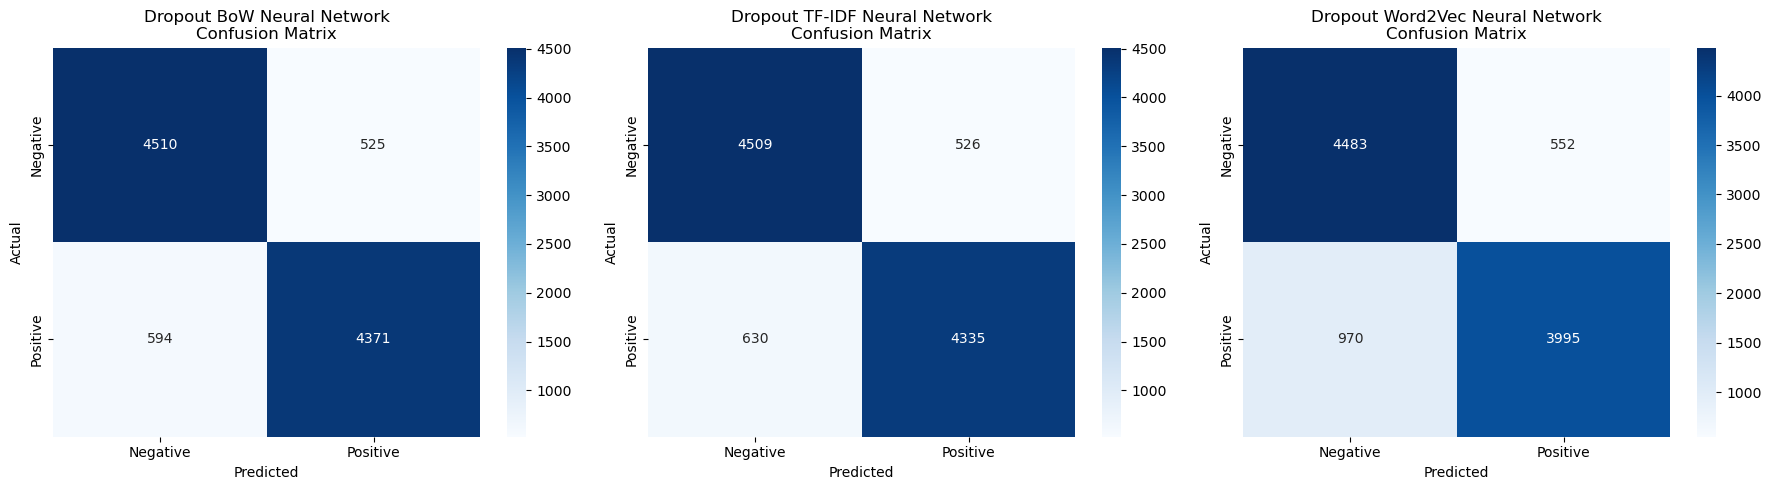

In [21]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_names = ['Negative', 'Positive']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

cm_bow = confusion_matrix(y_test, y_pred_labels)
sns.heatmap(cm_bow, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Dropout BoW Neural Network\nConfusion Matrix')

cm_tfidf = confusion_matrix(y_test, y_pred_tfidf_labels)
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Dropout TF-IDF Neural Network\nConfusion Matrix')

cm_w2v = confusion_matrix(y_test, y_pred_w2v_labels)
sns.heatmap(cm_w2v, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names, ax=axes[2])
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_title('Dropout Word2Vec Neural Network\nConfusion Matrix')

plt.tight_layout()
plt.show()

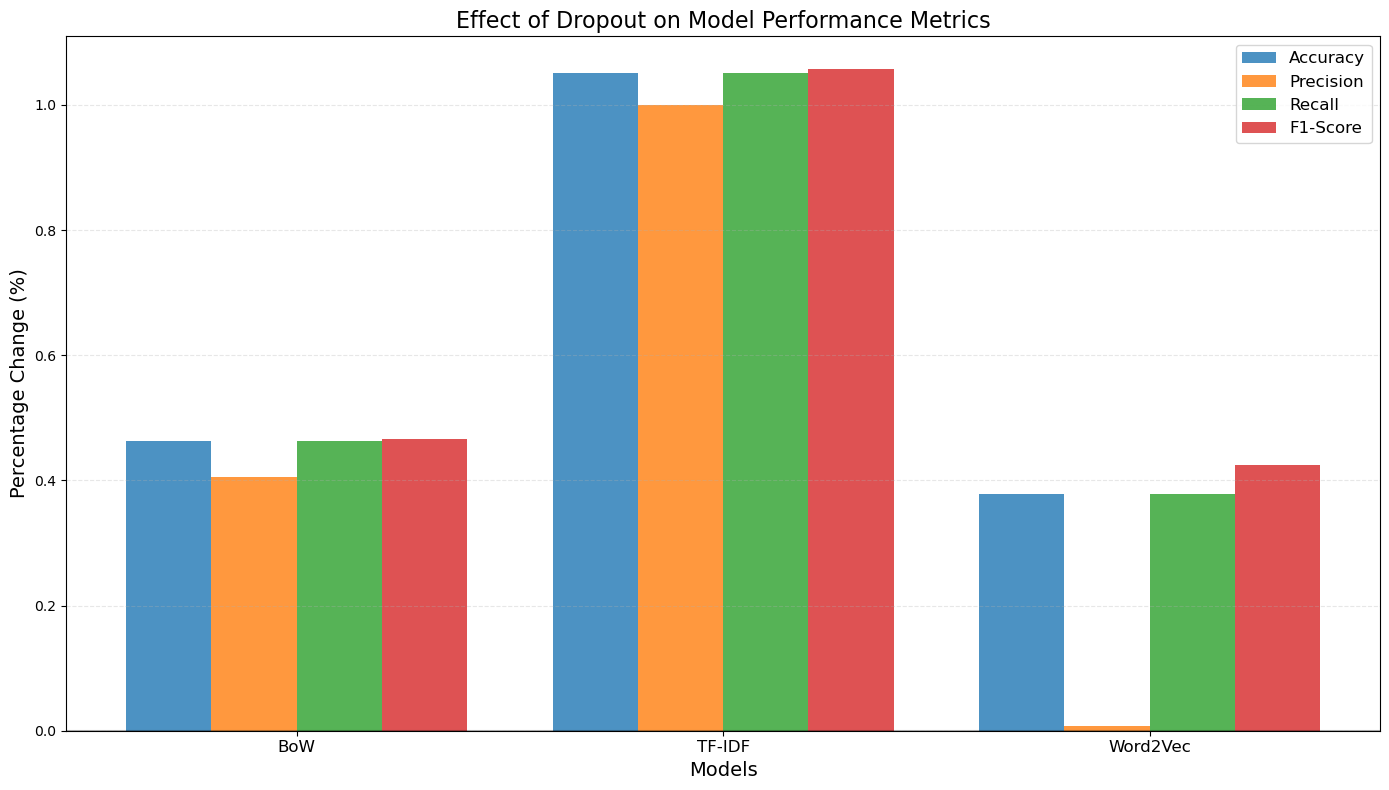

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

percentage_changes = {
    'BoW': {
        'Accuracy': ((drp_accuracy - accuracy) / accuracy * 100),
        'Precision': ((drp_precision - precision) / precision * 100),
        'Recall': ((drp_recall - recall) / recall * 100),
        'F1-Score': ((drp_f1 - f1) / f1 * 100)
    },
    'TF-IDF': {
        'Accuracy': ((drp_accuracy_tfidf - accuracy_tfidf) / accuracy_tfidf * 100),
        'Precision': ((drp_precision_tfidf - precision_tfidf) / precision_tfidf * 100),
        'Recall': ((drp_recall_tfidf - recall_tfidf) / recall_tfidf * 100),
        'F1-Score': ((drp_f1_tfidf - f1_tfidf) / f1_tfidf * 100)
    },
    'Word2Vec': {
        'Accuracy': ((drp_accuracy_w2v - accuracy_w2v) / accuracy_w2v * 100),
        'Precision': ((drp_precision_w2v - precision_w2v) / precision_w2v * 100),
        'Recall': ((drp_recall_w2v - recall_w2v) / recall_w2v * 100),
        'F1-Score': ((drp_f1_w2v - f1_w2v) / f1_w2v * 100)
    }
}

df = pd.DataFrame(percentage_changes)

plt.figure(figsize=(14, 8))

bar_width = 0.2
models = list(percentage_changes.keys())
metrics = list(percentage_changes['BoW'].keys())
x = np.arange(len(models))

for i, metric in enumerate(metrics):
    values = [percentage_changes[model][metric] for model in models]
    plt.bar(x + i * bar_width, values, width=bar_width, 
            label=metric, alpha=0.8)

plt.xlabel('Models', fontsize=14)
plt.ylabel('Percentage Change (%)', fontsize=14)
plt.title('Effect of Dropout on Model Performance Metrics', fontsize=16)
plt.xticks(x + bar_width * 1.5, models, fontsize=12)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)  # Zero line
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

## L2 Regularization
In this step, the effects of l2 regularization towards performance is explored. Other variables are left the same as the base experiment

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

X_train_vec_dense = X_train_vec.toarray()
X_test_vec_dense = X_test_vec.toarray()
X_train_tfidf_dense = X_train_tfidf.toarray()
X_test_tfidf_dense = X_test_tfidf.toarray()

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

l2_factor = 0.005

print("Training Neural Network with BoW features and L2 regularization...")
model = Sequential([
      Dense(32, activation='relu', input_shape=(X_train_vec_dense.shape[1],), 
              kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42),
              kernel_regularizer=l2(l2_factor)),
      Dense(4, activation='relu', 
              kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42),
              kernel_regularizer=l2(l2_factor)),
      Dense(2, activation='softmax', 
              kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42),
              kernel_regularizer=l2(l2_factor))
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_vec_dense, y_train_cat, epochs=5, batch_size=32, verbose=0)

print("Training Neural Network with TF-IDF features and L2 regularization...")
tfidf_model = Sequential([
      Dense(32, activation='relu', input_shape=(X_train_tfidf_dense.shape[1],), 
              kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42),
              kernel_regularizer=l2(l2_factor)),
      Dense(4, activation='relu', 
              kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42),
              kernel_regularizer=l2(l2_factor)),
      Dense(2, activation='softmax', 
              kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42),
              kernel_regularizer=l2(l2_factor))
])
tfidf_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
tfidf_model.fit(X_train_tfidf_dense, y_train_cat, epochs=5, batch_size=32, verbose=0)

print("Training Neural Network with Word2Vec features and L2 regularization...")
w2v_model_lr = Sequential([
      Dense(32, activation='relu', input_shape=(X_train_w2v.shape[1],), 
              kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42),
              kernel_regularizer=l2(l2_factor)),
      Dense(4, activation='relu', 
              kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42),
              kernel_regularizer=l2(l2_factor)),
      Dense(2, activation='softmax', 
              kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42),
              kernel_regularizer=l2(l2_factor))
])
w2v_model_lr.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
w2v_model_lr.fit(X_train_w2v, y_train_cat, epochs=5, batch_size=32, verbose=0)

print("Testing ann models with L2 regularization...")

y_pred_proba = model.predict(X_test_vec_dense)
y_pred_labels = np.argmax(y_pred_proba, axis=1)
l2_accuracy = accuracy_score(y_test, y_pred_labels)
l2_precision = precision_score(y_test, y_pred_labels, average='weighted')
l2_recall = recall_score(y_test, y_pred_labels, average='weighted')
l2_f1 = f1_score(y_test, y_pred_labels, average='weighted')

y_pred_tfidf_proba = tfidf_model.predict(X_test_tfidf_dense)
y_pred_tfidf_labels = np.argmax(y_pred_tfidf_proba, axis=1)
l2_accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf_labels)
l2_precision_tfidf = precision_score(y_test, y_pred_tfidf_labels, average='weighted')
l2_recall_tfidf = recall_score(y_test, y_pred_tfidf_labels, average='weighted')
l2_f1_tfidf = f1_score(y_test, y_pred_tfidf_labels, average='weighted')

y_pred_w2v_proba = w2v_model_lr.predict(X_test_w2v)
y_pred_w2v_labels = np.argmax(y_pred_w2v_proba, axis=1)
l2_accuracy_w2v = accuracy_score(y_test, y_pred_w2v_labels)
l2_precision_w2v = precision_score(y_test, y_pred_w2v_labels, average='weighted')
l2_recall_w2v = recall_score(y_test, y_pred_w2v_labels, average='weighted')
l2_f1_w2v = f1_score(y_test, y_pred_w2v_labels, average='weighted')

print("\nModel Comparison (with L2 Regularization):")
print("CountVectorizer + Neural Network:")
print(f"  Accuracy:  {l2_accuracy:.4f}")
print(f"  Precision: {l2_precision:.4f}")
print(f"  Recall:    {l2_recall:.4f}")
print(f"  F1-Score:  {l2_f1:.4f}")
print("\nTF-IDF + Neural Network:")
print(f"  Accuracy:  {l2_accuracy_tfidf:.4f}")
print(f"  Precision: {l2_precision_tfidf:.4f}")
print(f"  Recall:    {l2_recall_tfidf:.4f}")
print(f"  F1-Score:  {l2_f1_tfidf:.4f}")
print("\nWord2Vec + Neural Network:")
print(f"  Accuracy:  {l2_accuracy_w2v:.4f}")
print(f"  Precision: {l2_precision_w2v:.4f}")
print(f"  Recall:    {l2_recall_w2v:.4f}")
print(f"  F1-Score:  {l2_f1_w2v:.4f}")

print("\nPercentage Changes from Base Experiment:")
print("CountVectorizer + Neural Network:")
print(f"  Accuracy:  {((l2_accuracy - accuracy) / accuracy * 100):.2f}%")
print(f"  Precision: {((l2_precision - precision) / precision * 100):.2f}%")
print(f"  Recall:    {((l2_recall - recall) / recall * 100):.2f}%")
print(f"  F1-Score:  {((l2_f1 - f1) / f1 * 100):.2f}%")
print("\nTF-IDF + Neural Network:")
print(f"  Accuracy:  {((l2_accuracy_tfidf - accuracy_tfidf) / accuracy_tfidf * 100):.2f}%")
print(f"  Precision: {((l2_precision_tfidf - precision_tfidf) / precision_tfidf * 100):.2f}%")
print(f"  Recall:    {((l2_recall_tfidf - recall_tfidf) / recall_tfidf * 100):.2f}%")
print(f"  F1-Score:  {((l2_f1_tfidf - f1_tfidf) / f1_tfidf * 100):.2f}%")
print("\nWord2Vec + Neural Network:")
print(f"  Accuracy:  {((l2_accuracy_w2v - accuracy_w2v) / accuracy_w2v * 100):.2f}%")
print(f"  Precision: {((l2_precision_w2v - precision_w2v) / precision_w2v * 100):.2f}%")
print(f"  Recall:    {((l2_recall_w2v - recall_w2v) / recall_w2v * 100):.2f}%")
print(f"  F1-Score:  {((l2_f1_w2v - f1_w2v) / f1_w2v * 100):.2f}%")

Training Neural Network with BoW features and L2 regularization...
Training Neural Network with TF-IDF features and L2 regularization...
Training Neural Network with Word2Vec features and L2 regularization...
Testing ann models with L2 regularization...
313/313 [==============================] - 0s 275us/step

Model Comparison (with L2 Regularization):
CountVectorizer + Neural Network:
  Accuracy:  0.8879
  Precision: 0.8879
  Recall:    0.8879
  F1-Score:  0.8879

TF-IDF + Neural Network:
  Accuracy:  0.8849
  Precision: 0.8854
  Recall:    0.8849
  F1-Score:  0.8849

Word2Vec + Neural Network:
  Accuracy:  0.8207
  Precision: 0.8332
  Recall:    0.8207
  F1-Score:  0.8188

Percentage Changes from Base Experiment:
CountVectorizer + Neural Network:
  Accuracy:  0.44%
  Precision: 0.38%
  Recall:    0.44%
  F1-Score:  0.44%

TF-IDF + Neural Network:
  Accuracy:  1.11%
  Precision: 1.09%
  Recall:    1.11%
  F1-Score:  1.11%

Word2Vec + Neural Network:
  Accuracy:  -2.83%
  Precision: -1

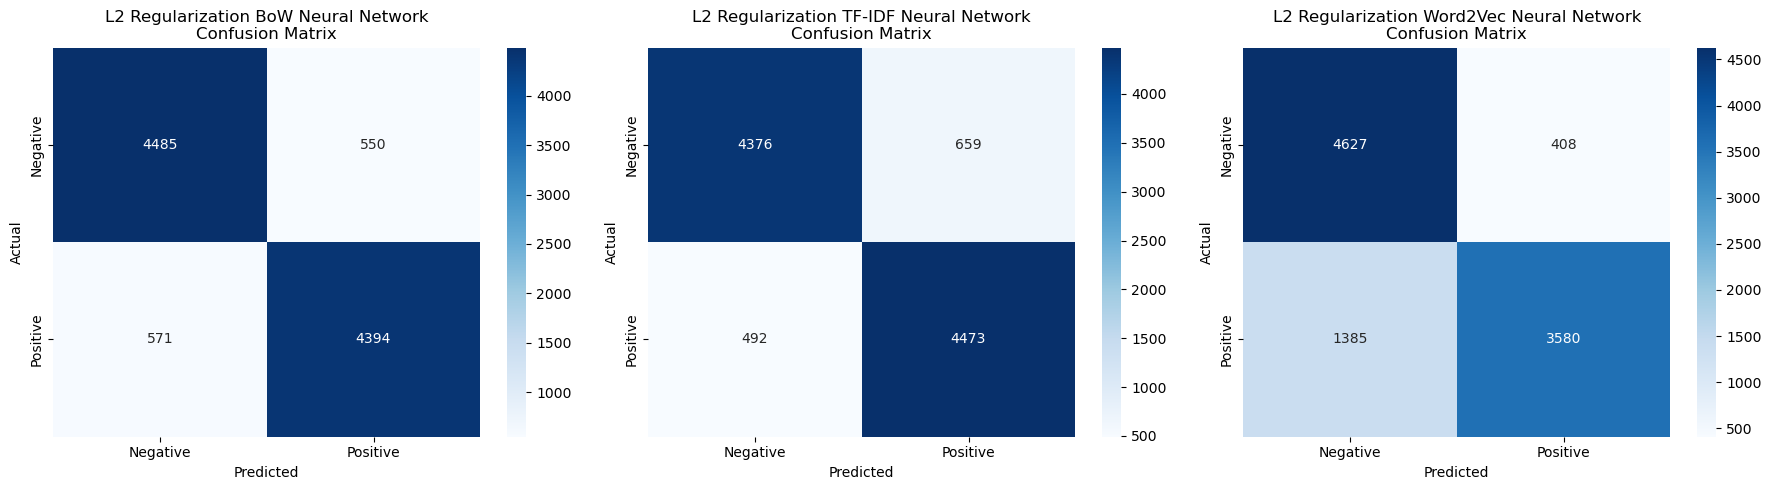

In [24]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_names = ['Negative', 'Positive']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

cm_bow = confusion_matrix(y_test, y_pred_labels)
sns.heatmap(cm_bow, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('L2 Regularization BoW Neural Network\nConfusion Matrix')

cm_tfidf = confusion_matrix(y_test, y_pred_tfidf_labels)
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('L2 Regularization TF-IDF Neural Network\nConfusion Matrix')

cm_w2v = confusion_matrix(y_test, y_pred_w2v_labels)
sns.heatmap(cm_w2v, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names, ax=axes[2])
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_title('L2 Regularization Word2Vec Neural Network\nConfusion Matrix')

plt.tight_layout()
plt.show()

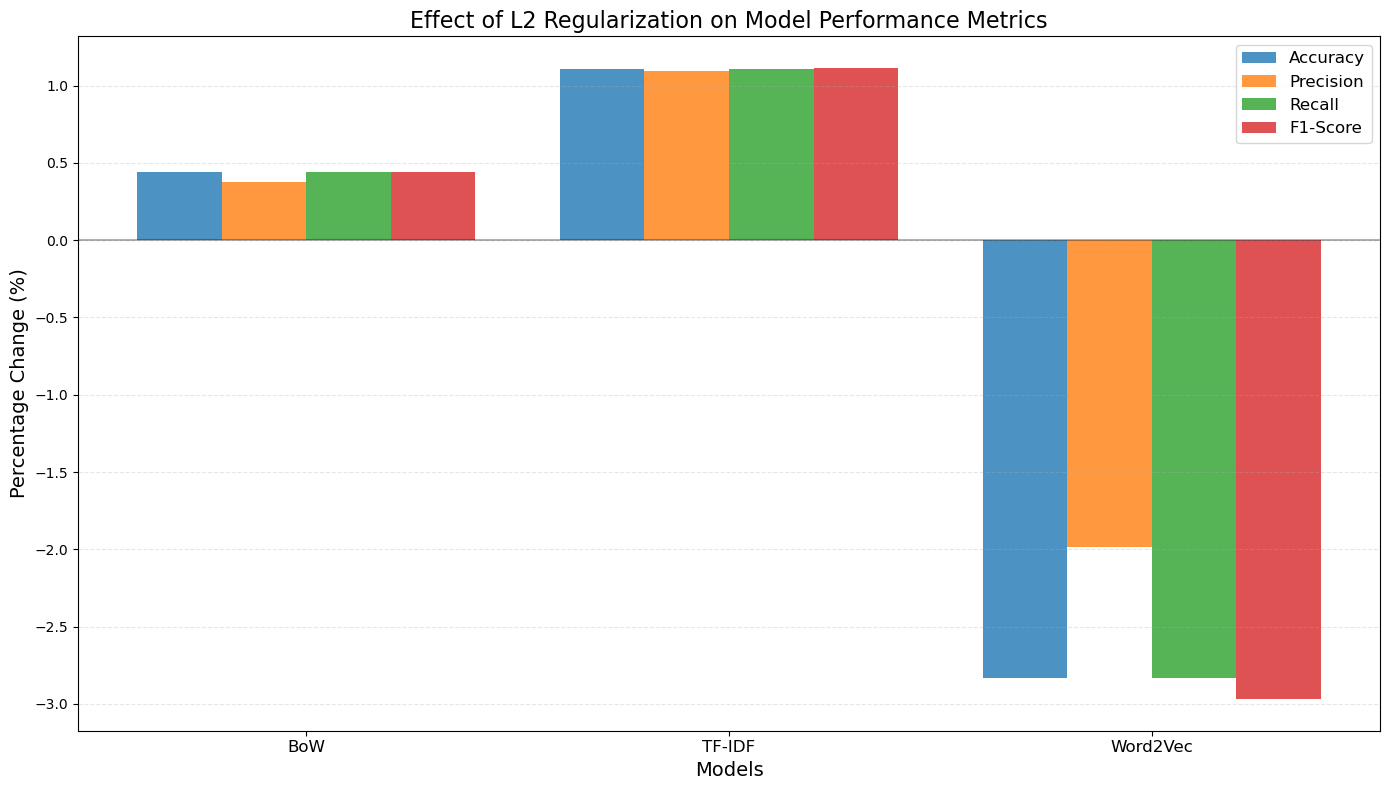

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

percentage_changes = {
    'BoW': {
        'Accuracy': ((l2_accuracy - accuracy) / accuracy * 100),
        'Precision': ((l2_precision - precision) / precision * 100),
        'Recall': ((l2_recall - recall) / recall * 100),
        'F1-Score': ((l2_f1 - f1) / f1 * 100)
    },
    'TF-IDF': {
        'Accuracy': ((l2_accuracy_tfidf - accuracy_tfidf) / accuracy_tfidf * 100),
        'Precision': ((l2_precision_tfidf - precision_tfidf) / precision_tfidf * 100),
        'Recall': ((l2_recall_tfidf - recall_tfidf) / recall_tfidf * 100),
        'F1-Score': ((l2_f1_tfidf - f1_tfidf) / f1_tfidf * 100)
    },
    'Word2Vec': {
        'Accuracy': ((l2_accuracy_w2v - accuracy_w2v) / accuracy_w2v * 100),
        'Precision': ((l2_precision_w2v - precision_w2v) / precision_w2v * 100),
        'Recall': ((l2_recall_w2v - recall_w2v) / recall_w2v * 100),
        'F1-Score': ((l2_f1_w2v - f1_w2v) / f1_w2v * 100)
    }
}

df = pd.DataFrame(percentage_changes)

plt.figure(figsize=(14, 8))

bar_width = 0.2
models = list(percentage_changes.keys())
metrics = list(percentage_changes['BoW'].keys())
x = np.arange(len(models))

for i, metric in enumerate(metrics):
    values = [percentage_changes[model][metric] for model in models]
    plt.bar(x + i * bar_width, values, width=bar_width, 
            label=metric, alpha=0.8)

plt.xlabel('Models', fontsize=14)
plt.ylabel('Percentage Change (%)', fontsize=14)
plt.title('Effect of L2 Regularization on Model Performance Metrics', fontsize=16)
plt.xticks(x + bar_width * 1.5, models, fontsize=12)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)  # Zero line
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

## Early stopping
In this step, the effects of early stopping towards performance is explored. Other variables are left the same as the base experiment

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

X_train_vec_dense = X_train_vec.toarray()
X_test_vec_dense = X_test_vec.toarray()
X_train_tfidf_dense = X_train_tfidf.toarray()
X_test_tfidf_dense = X_test_tfidf.toarray()

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

print("Training Neural Network with BoW features and early stopping...")
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_vec_dense.shape[1],), 
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
    Dense(4, activation='relu', 
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
    Dense(2, activation='softmax', 
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_vec_dense, y_train_cat, 
          epochs=30, batch_size=32, verbose=0,
          validation_split=0.1,
          callbacks=[early_stopping])

print("Training Neural Network with TF-IDF features and early stopping...")
tfidf_model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_tfidf_dense.shape[1],), 
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
    Dense(4, activation='relu', 
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
    Dense(2, activation='softmax', 
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
])
tfidf_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
tfidf_model.fit(X_train_tfidf_dense, y_train_cat, 
                epochs=30, batch_size=32, verbose=0,
                validation_split=0.1,
                callbacks=[early_stopping])

print("Training Neural Network with Word2Vec features and early stopping...")
w2v_model_lr = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_w2v.shape[1],), 
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
    Dense(4, activation='relu', 
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
    Dense(2, activation='softmax', 
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
])
w2v_model_lr.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
w2v_model_lr.fit(X_train_w2v, y_train_cat, 
                 epochs=30, batch_size=32, verbose=0,
                 validation_split=0.1,
                 callbacks=[early_stopping])

print("Testing ann models with early stopping...")


y_pred_proba = model.predict(X_test_vec_dense)
y_pred_labels = np.argmax(y_pred_proba, axis=1)
es_accuracy = accuracy_score(y_test, y_pred_labels)
es_precision = precision_score(y_test, y_pred_labels, average='weighted')
es_recall = recall_score(y_test, y_pred_labels, average='weighted')
es_f1 = f1_score(y_test, y_pred_labels, average='weighted')

y_pred_tfidf_proba = tfidf_model.predict(X_test_tfidf_dense)
y_pred_tfidf_labels = np.argmax(y_pred_tfidf_proba, axis=1)
es_accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf_labels)
es_precision_tfidf = precision_score(y_test, y_pred_tfidf_labels, average='weighted')
es_recall_tfidf = recall_score(y_test, y_pred_tfidf_labels, average='weighted')
es_f1_tfidf = f1_score(y_test, y_pred_tfidf_labels, average='weighted')

y_pred_w2v_proba = w2v_model_lr.predict(X_test_w2v)
y_pred_w2v_labels = np.argmax(y_pred_w2v_proba, axis=1)
es_accuracy_w2v = accuracy_score(y_test, y_pred_w2v_labels)
es_precision_w2v = precision_score(y_test, y_pred_w2v_labels, average='weighted')
es_recall_w2v = recall_score(y_test, y_pred_w2v_labels, average='weighted')
es_f1_w2v = f1_score(y_test, y_pred_w2v_labels, average='weighted')

print("\nModel Comparison (with Early Stopping):")
print("CountVectorizer + Neural Network:")
print(f"  Accuracy:  {es_accuracy:.4f}")
print(f"  Precision: {es_precision:.4f}")
print(f"  Recall:    {es_recall:.4f}")
print(f"  F1-Score:  {es_f1:.4f}")
print("\nTF-IDF + Neural Network:")
print(f"  Accuracy:  {es_accuracy_tfidf:.4f}")
print(f"  Precision: {es_precision_tfidf:.4f}")
print(f"  Recall:    {es_recall_tfidf:.4f}")
print(f"  F1-Score:  {es_f1_tfidf:.4f}")
print("\nWord2Vec + Neural Network:")
print(f"  Accuracy:  {es_accuracy_w2v:.4f}")
print(f"  Precision: {es_precision_w2v:.4f}")
print(f"  Recall:    {es_recall_w2v:.4f}")
print(f"  F1-Score:  {es_f1_w2v:.4f}")

print("\nPercentage Changes from Base Experiment:")
print("CountVectorizer + Neural Network:")
print(f"  Accuracy:  {((es_accuracy - accuracy) / accuracy * 100):.2f}%")
print(f"  Precision: {((es_precision - precision) / precision * 100):.2f}%")
print(f"  Recall:    {((es_recall - recall) / recall * 100):.2f}%")
print(f"  F1-Score:  {((es_f1 - f1) / f1 * 100):.2f}%")
print("\nTF-IDF + Neural Network:")
print(f"  Accuracy:  {((es_accuracy_tfidf - accuracy_tfidf) / accuracy_tfidf * 100):.2f}%")
print(f"  Precision: {((es_precision_tfidf - precision_tfidf) / precision_tfidf * 100):.2f}%")
print(f"  Recall:    {((es_recall_tfidf - recall_tfidf) / recall_tfidf * 100):.2f}%")
print(f"  F1-Score:  {((es_f1_tfidf - f1_tfidf) / f1_tfidf * 100):.2f}%")
print("\nWord2Vec + Neural Network:")
print(f"  Accuracy:  {((es_accuracy_w2v - accuracy_w2v) / accuracy_w2v * 100):.2f}%")
print(f"  Precision: {((es_precision_w2v - precision_w2v) / precision_w2v * 100):.2f}%")
print(f"  Recall:    {((es_recall_w2v - recall_w2v) / recall_w2v * 100):.2f}%")
print(f"  F1-Score:  {((es_f1_w2v - f1_w2v) / f1_w2v * 100):.2f}%")

Training Neural Network with BoW features and early stopping...
Restoring model weights from the end of the best epoch: 1.
Epoch 6: early stopping
Training Neural Network with TF-IDF features and early stopping...
Restoring model weights from the end of the best epoch: 1.
Epoch 6: early stopping
Training Neural Network with Word2Vec features and early stopping...
Restoring model weights from the end of the best epoch: 9.
Epoch 14: early stopping
Testing ann models with early stopping...
313/313 [==============================] - 0s 277us/step

Model Comparison (with Early Stopping):
CountVectorizer + Neural Network:
  Accuracy:  0.8956
  Precision: 0.8957
  Recall:    0.8956
  F1-Score:  0.8956

TF-IDF + Neural Network:
  Accuracy:  0.8995
  Precision: 0.8999
  Recall:    0.8995
  F1-Score:  0.8995

Word2Vec + Neural Network:
  Accuracy:  0.8601
  Precision: 0.8603
  Recall:    0.8601
  F1-Score:  0.8601

Percentage Changes from Base Experiment:
CountVectorizer + Neural Network:
  Accu

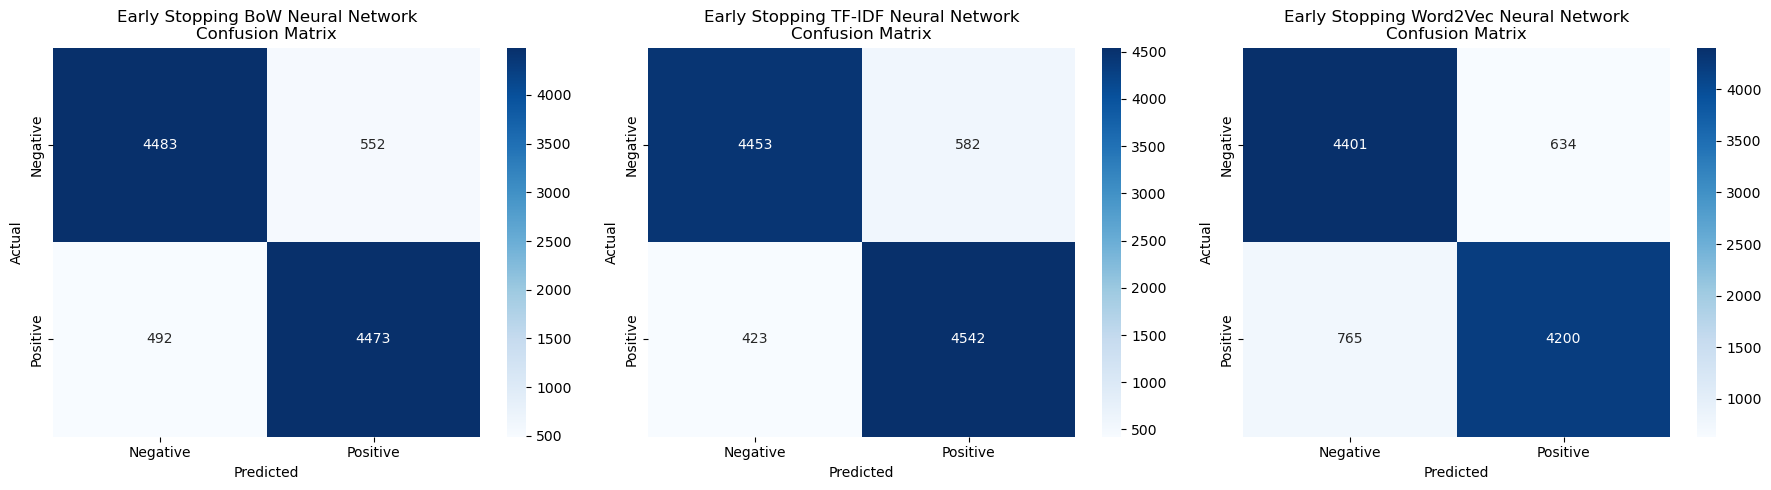

In [27]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_names = ['Negative', 'Positive']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

cm_bow = confusion_matrix(y_test, y_pred_labels)
sns.heatmap(cm_bow, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Early Stopping BoW Neural Network\nConfusion Matrix')

cm_tfidf = confusion_matrix(y_test, y_pred_tfidf_labels)
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Early Stopping TF-IDF Neural Network\nConfusion Matrix')

cm_w2v = confusion_matrix(y_test, y_pred_w2v_labels)
sns.heatmap(cm_w2v, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names, ax=axes[2])
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_title('Early Stopping Word2Vec Neural Network\nConfusion Matrix')

plt.tight_layout()
plt.show()

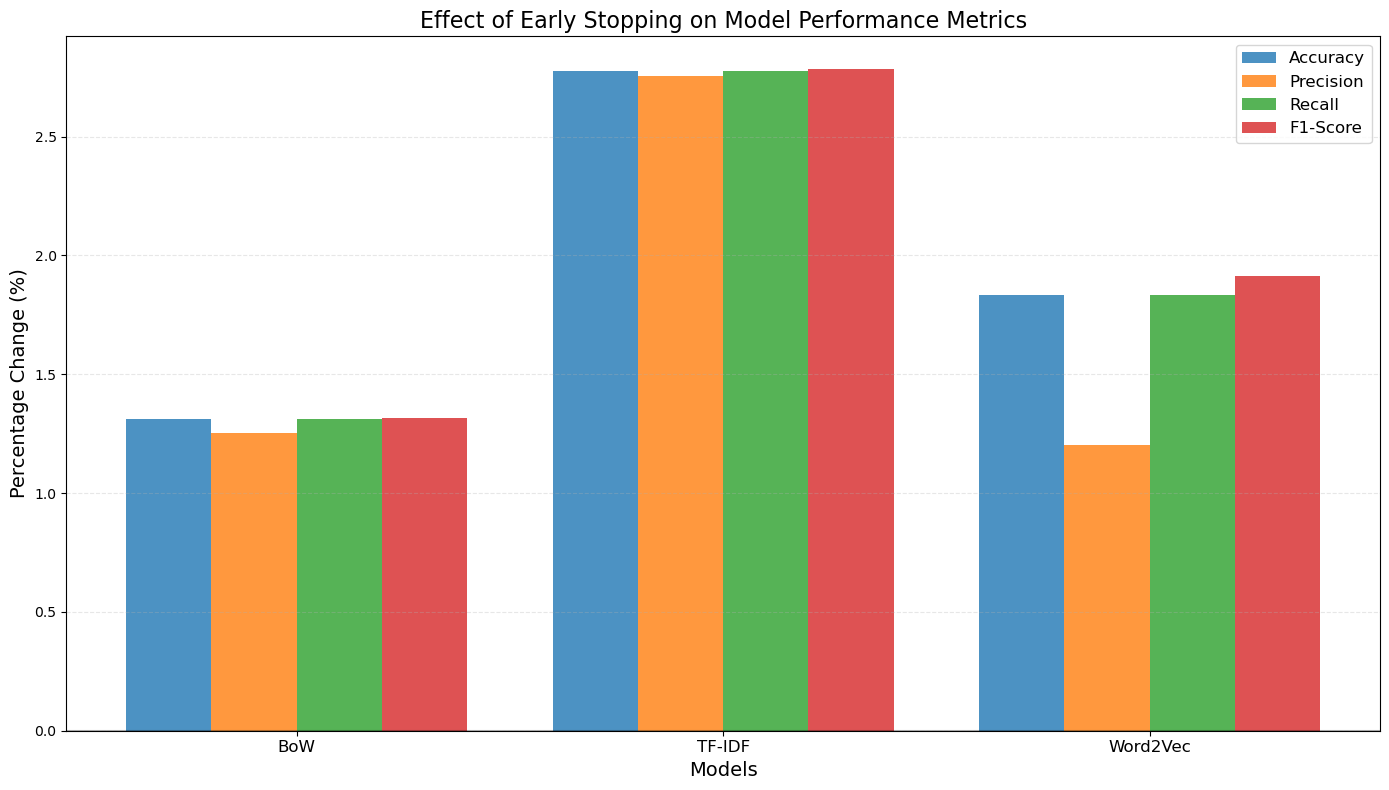

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

percentage_changes = {
    'BoW': {
        'Accuracy': ((es_accuracy - accuracy) / accuracy * 100),
        'Precision': ((es_precision - precision) / precision * 100),
        'Recall': ((es_recall - recall) / recall * 100),
        'F1-Score': ((es_f1 - f1) / f1 * 100)
    },
    'TF-IDF': {
        'Accuracy': ((es_accuracy_tfidf - accuracy_tfidf) / accuracy_tfidf * 100),
        'Precision': ((es_precision_tfidf - precision_tfidf) / precision_tfidf * 100),
        'Recall': ((es_recall_tfidf - recall_tfidf) / recall_tfidf * 100),
        'F1-Score': ((es_f1_tfidf - f1_tfidf) / f1_tfidf * 100)
    },
    'Word2Vec': {
        'Accuracy': ((es_accuracy_w2v - accuracy_w2v) / accuracy_w2v * 100),
        'Precision': ((es_precision_w2v - precision_w2v) / precision_w2v * 100),
        'Recall': ((es_recall_w2v - recall_w2v) / recall_w2v * 100),
        'F1-Score': ((es_f1_w2v - f1_w2v) / f1_w2v * 100)
    }
}

df = pd.DataFrame(percentage_changes)

plt.figure(figsize=(14, 8))

bar_width = 0.2
models = list(percentage_changes.keys())
metrics = list(percentage_changes['BoW'].keys())
x = np.arange(len(models))

for i, metric in enumerate(metrics):
    values = [percentage_changes[model][metric] for model in models]
    plt.bar(x + i * bar_width, values, width=bar_width, 
            label=metric, alpha=0.8)

plt.xlabel('Models', fontsize=14)
plt.ylabel('Percentage Change (%)', fontsize=14)
plt.title('Effect of Early Stopping on Model Performance Metrics', fontsize=16)
plt.xticks(x + bar_width * 1.5, models, fontsize=12)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)  # Zero line
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

## Batch normalization
In this step, the effects of early stopping towards performance is explored. Other variables are left the same as the base experiment

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
import numpy as np
import tensorflow as tf


np.random.seed(42)
tf.random.set_seed(42)


X_train_vec_dense = X_train_vec.toarray()
X_test_vec_dense = X_test_vec.toarray()
X_train_tfidf_dense = X_train_tfidf.toarray()
X_test_tfidf_dense = X_test_tfidf.toarray()


y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

print("Training Neural Network with BoW features and batch normalization...")
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_vec_dense.shape[1],), 
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
    BatchNormalization(),  # Add batch normalization layer
    Dense(4, activation='relu', 
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
    BatchNormalization(),  # Add batch normalization layer
    Dense(2, activation='softmax', 
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_vec_dense, y_train_cat, epochs=5, batch_size=32, verbose=0)

print("Training Neural Network with TF-IDF features and batch normalization...")
tfidf_model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_tfidf_dense.shape[1],), 
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
    # Notice no normalization after input layer. since tf-idf is already normalized, prevent double normalization 
    Dense(4, activation='relu', 
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
    BatchNormalization(),  # Add batch normalization layer
    Dense(2, activation='softmax', 
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
])
tfidf_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
tfidf_model.fit(X_train_tfidf_dense, y_train_cat, epochs=5, batch_size=32, verbose=0)

print("Training Neural Network with Word2Vec features and batch normalization...")
w2v_model_lr = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_w2v.shape[1],), 
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
    BatchNormalization(),  # Add batch normalization layer
    Dense(4, activation='relu', 
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42)),
    BatchNormalization(),  # Add batch normalization layer
    Dense(2, activation='softmax', 
          kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
])
w2v_model_lr.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
w2v_model_lr.fit(X_train_w2v, y_train_cat, epochs=5, batch_size=32, verbose=0)

print("Testing ann models with batch normalization...")

y_pred_proba = model.predict(X_test_vec_dense)
y_pred_labels = np.argmax(y_pred_proba, axis=1)
bn_accuracy = accuracy_score(y_test, y_pred_labels)
bn_precision = precision_score(y_test, y_pred_labels, average='weighted')
bn_recall = recall_score(y_test, y_pred_labels, average='weighted')
bn_f1 = f1_score(y_test, y_pred_labels, average='weighted')

y_pred_tfidf_proba = tfidf_model.predict(X_test_tfidf_dense)
y_pred_tfidf_labels = np.argmax(y_pred_tfidf_proba, axis=1)
bn_accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf_labels)
bn_precision_tfidf = precision_score(y_test, y_pred_tfidf_labels, average='weighted')
bn_recall_tfidf = recall_score(y_test, y_pred_tfidf_labels, average='weighted')
bn_f1_tfidf = f1_score(y_test, y_pred_tfidf_labels, average='weighted')

y_pred_w2v_proba = w2v_model_lr.predict(X_test_w2v)
y_pred_w2v_labels = np.argmax(y_pred_w2v_proba, axis=1)
bn_accuracy_w2v = accuracy_score(y_test, y_pred_w2v_labels)
bn_precision_w2v = precision_score(y_test, y_pred_w2v_labels, average='weighted')
bn_recall_w2v = recall_score(y_test, y_pred_w2v_labels, average='weighted')
bn_f1_w2v = f1_score(y_test, y_pred_w2v_labels, average='weighted')

print("\nModel Comparison (with Batch Normalization):")
print("CountVectorizer + Neural Network:")
print(f"  Accuracy:  {bn_accuracy:.4f}")
print(f"  Precision: {bn_precision:.4f}")
print(f"  Recall:    {bn_recall:.4f}")
print(f"  F1-Score:  {bn_f1:.4f}")
print("\nTF-IDF + Neural Network:")
print(f"  Accuracy:  {bn_accuracy_tfidf:.4f}")
print(f"  Precision: {bn_precision_tfidf:.4f}")
print(f"  Recall:    {bn_recall_tfidf:.4f}")
print(f"  F1-Score:  {bn_f1_tfidf:.4f}")
print("\nWord2Vec + Neural Network:")
print(f"  Accuracy:  {bn_accuracy_w2v:.4f}")
print(f"  Precision: {bn_precision_w2v:.4f}")
print(f"  Recall:    {bn_recall_w2v:.4f}")
print(f"  F1-Score:  {bn_f1_w2v:.4f}")

print("\nPercentage Changes from Base Experiment:")
print("CountVectorizer + Neural Network:")
print(f"  Accuracy:  {((bn_accuracy - accuracy) / accuracy * 100):.2f}%")
print(f"  Precision: {((bn_precision - precision) / precision * 100):.2f}%")
print(f"  Recall:    {((bn_recall - recall) / recall * 100):.2f}%")
print(f"  F1-Score:  {((bn_f1 - f1) / f1 * 100):.2f}%")
print("\nTF-IDF + Neural Network:")
print(f"  Accuracy:  {((bn_accuracy_tfidf - accuracy_tfidf) / accuracy_tfidf * 100):.2f}%")
print(f"  Precision: {((bn_precision_tfidf - precision_tfidf) / precision_tfidf * 100):.2f}%")
print(f"  Recall:    {((bn_recall_tfidf - recall_tfidf) / recall_tfidf * 100):.2f}%")
print(f"  F1-Score:  {((bn_f1_tfidf - f1_tfidf) / f1_tfidf * 100):.2f}%")
print("\nWord2Vec + Neural Network:")
print(f"  Accuracy:  {((bn_accuracy_w2v - accuracy_w2v) / accuracy_w2v * 100):.2f}%")
print(f"  Precision: {((bn_precision_w2v - precision_w2v) / precision_w2v * 100):.2f}%")
print(f"  Recall:    {((bn_recall_w2v - recall_w2v) / recall_w2v * 100):.2f}%")
print(f"  F1-Score:  {((bn_f1_w2v - f1_w2v) / f1_w2v * 100):.2f}%")

Training Neural Network with BoW features and batch normalization...
Training Neural Network with TF-IDF features and batch normalization...
Training Neural Network with Word2Vec features and batch normalization...
Testing ann models with batch normalization...
313/313 [==============================] - 0s 280us/step

Model Comparison (with Batch Normalization):
CountVectorizer + Neural Network:
  Accuracy:  0.8886
  Precision: 0.8890
  Recall:    0.8886
  F1-Score:  0.8886

TF-IDF + Neural Network:
  Accuracy:  0.8830
  Precision: 0.8838
  Recall:    0.8830
  F1-Score:  0.8829

Word2Vec + Neural Network:
  Accuracy:  0.8480
  Precision: 0.8521
  Recall:    0.8480
  F1-Score:  0.8475

Percentage Changes from Base Experiment:
CountVectorizer + Neural Network:
  Accuracy:  0.52%
  Precision: 0.50%
  Recall:    0.52%
  F1-Score:  0.52%

TF-IDF + Neural Network:
  Accuracy:  0.89%
  Precision: 0.91%
  Recall:    0.89%
  F1-Score:  0.89%

Word2Vec + Neural Network:
  Accuracy:  0.40%
  Prec

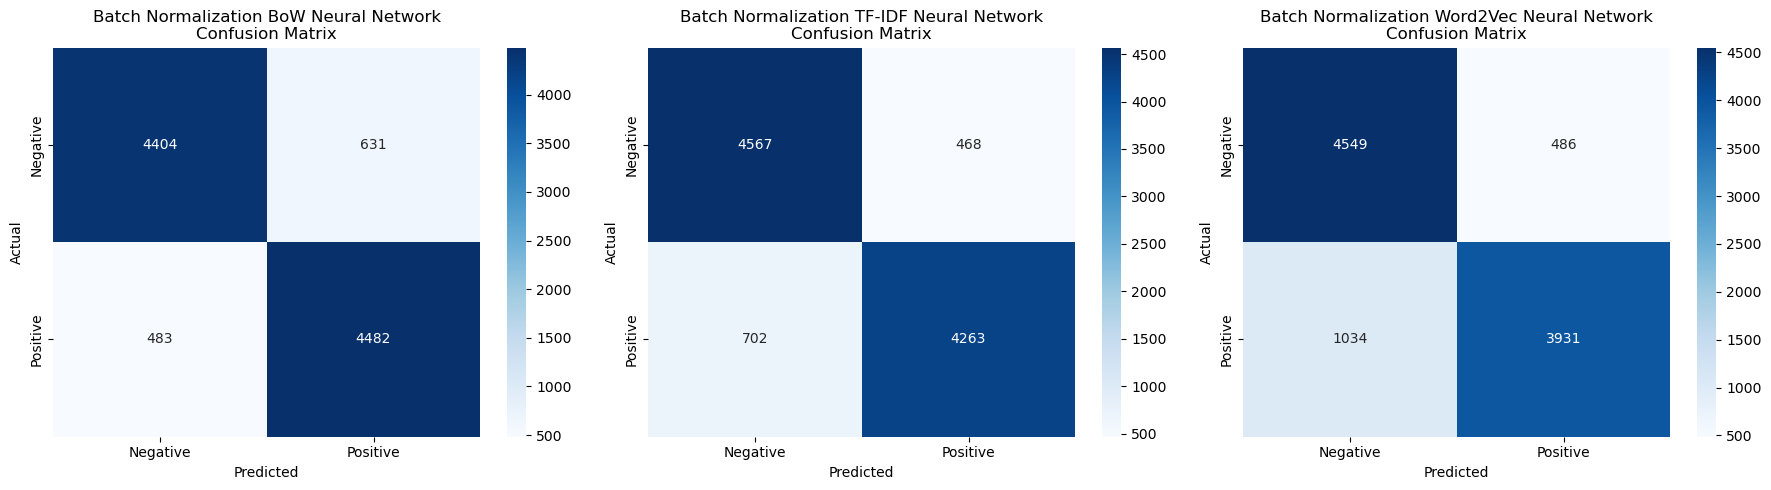

In [30]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_names = ['Negative', 'Positive']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

cm_bow = confusion_matrix(y_test, y_pred_labels)
sns.heatmap(cm_bow, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Batch Normalization BoW Neural Network\nConfusion Matrix')

cm_tfidf = confusion_matrix(y_test, y_pred_tfidf_labels)
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Batch Normalization TF-IDF Neural Network\nConfusion Matrix')

cm_w2v = confusion_matrix(y_test, y_pred_w2v_labels)
sns.heatmap(cm_w2v, annot=True, fmt='d', cmap='Blues', 
           xticklabels=class_names, yticklabels=class_names, ax=axes[2])
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_title('Batch Normalization Word2Vec Neural Network\nConfusion Matrix')

plt.tight_layout()
plt.show()

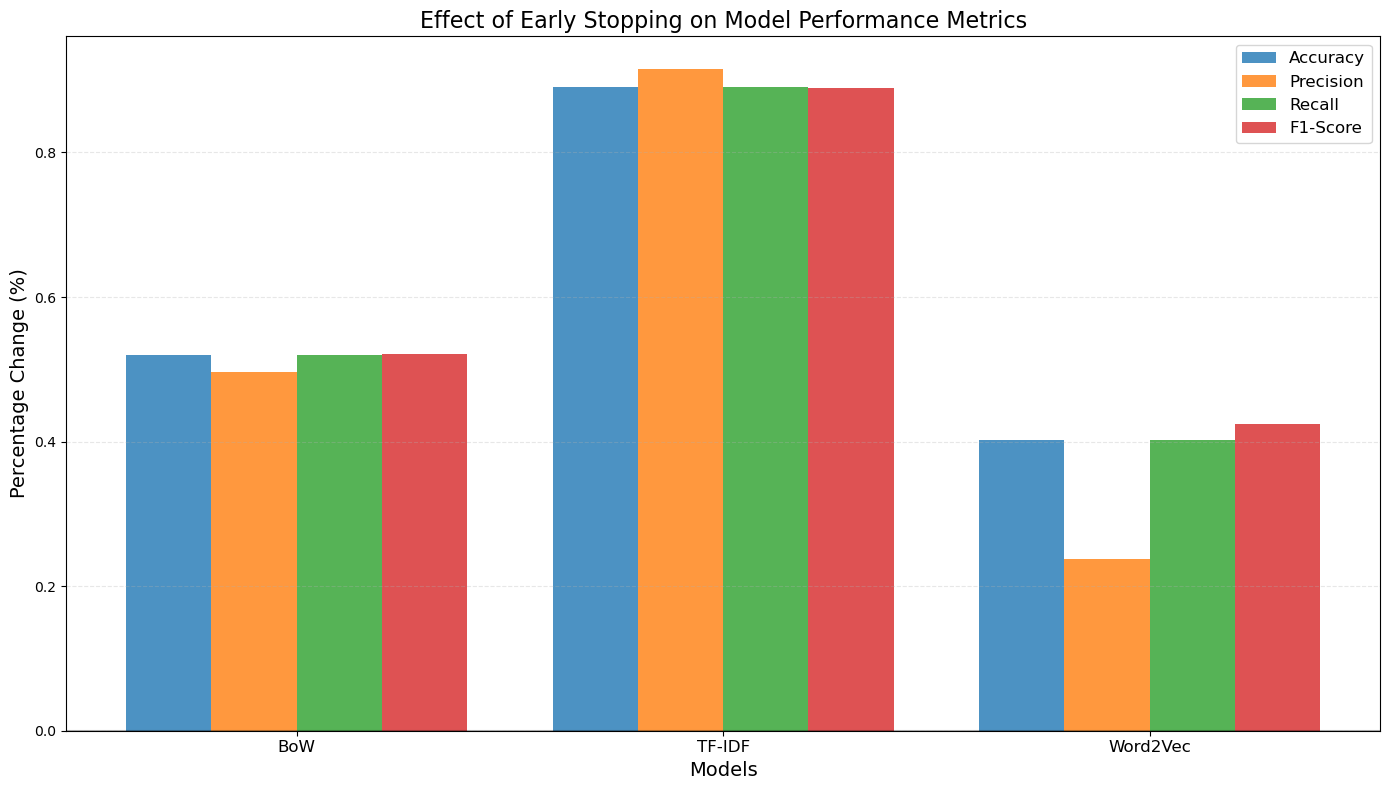

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

percentage_changes = {
    'BoW': {
        'Accuracy': ((bn_accuracy - accuracy) / accuracy * 100),
        'Precision': ((bn_precision - precision) / precision * 100),
        'Recall': ((bn_recall - recall) / recall * 100),
        'F1-Score': ((bn_f1 - f1) / f1 * 100)
    },
    'TF-IDF': {
        'Accuracy': ((bn_accuracy_tfidf - accuracy_tfidf) / accuracy_tfidf * 100),
        'Precision': ((bn_precision_tfidf - precision_tfidf) / precision_tfidf * 100),
        'Recall': ((bn_recall_tfidf - recall_tfidf) / recall_tfidf * 100),
        'F1-Score': ((bn_f1_tfidf - f1_tfidf) / f1_tfidf * 100)
    },
    'Word2Vec': {
        'Accuracy': ((bn_accuracy_w2v - accuracy_w2v) / accuracy_w2v * 100),
        'Precision': ((bn_precision_w2v - precision_w2v) / precision_w2v * 100),
        'Recall': ((bn_recall_w2v - recall_w2v) / recall_w2v * 100),
        'F1-Score': ((bn_f1_w2v - f1_w2v) / f1_w2v * 100)
    }
}

df = pd.DataFrame(percentage_changes)

plt.figure(figsize=(14, 8))

bar_width = 0.2
models = list(percentage_changes.keys())
metrics = list(percentage_changes['BoW'].keys())
x = np.arange(len(models))

for i, metric in enumerate(metrics):
    values = [percentage_changes[model][metric] for model in models]
    plt.bar(x + i * bar_width, values, width=bar_width, 
            label=metric, alpha=0.8)

plt.xlabel('Models', fontsize=14)
plt.ylabel('Percentage Change (%)', fontsize=14)
plt.title('Effect of Early Stopping on Model Performance Metrics', fontsize=16)
plt.xticks(x + bar_width * 1.5, models, fontsize=12)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)  # Zero line
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()